### Packages Import

In [1]:
import pandas as pd
import numpy as np
from time import time 

import sklearn 
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.metrics import fbeta_score, accuracy_score
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import make_scorer
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import LabelBinarizer
from sklearn.metrics import roc_curve, roc_auc_score
from sklearn.metrics import confusion_matrix
from sklearn.pipeline import Pipeline

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import GradientBoostingClassifier

from xgboost import XGBClassifier

import matplotlib.pyplot as plt
from matplotlib import cm

import seaborn as sns; sns.set()
%matplotlib inline

### Upload and Analyze Data

In [2]:
features_name = pd.read_csv('features.txt', header = None)

features_name = features_name[0].apply(lambda x: x.rstrip())

features_names = features_name.tolist()
features_names[:3]

['tBodyAcc-Mean-1', 'tBodyAcc-Mean-2', 'tBodyAcc-Mean-3']

In [3]:
len(features_names)

561

In [4]:
len(set(features_names))

533

We can see that there are some columns with the same name. However, we checked and those are not duplicated values, thus we will keep them as they are.

In [5]:
activity_labels = pd.read_csv('activity_labels.txt', header = None) 
activity_labels.head(2)

,0
0,1 WALKING
1,2 WALKING_UPSTAIRS


In [6]:
label_names = pd.DataFrame()

label_names[['Target', 'Activity']] = activity_labels[0].str.split(' ', 1, expand=True)

label_names['Target'] = label_names['Target'].astype(int)
label_names['Activity'] = label_names['Activity'].apply(lambda x: x.rstrip())

In [7]:
label_names

,Target,Activity
0,1,WALKING
1,2,WALKING_UPSTAIRS
2,3,WALKING_DOWNSTAIRS
3,4,SITTING
4,5,STANDING
5,6,LAYING
6,7,STAND_TO_SIT
7,8,SIT_TO_STAND
8,9,SIT_TO_LIE
9,10,LIE_TO_SIT


* ### Training 

In [8]:
features_train = pd.read_csv('X_train.txt', sep = ' ', header = None)
features_train.columns = features_names

target_train = pd.read_csv('y_train.txt', header = None, names = ['Target'])

#### Target

In [9]:
target_train.shape

(7767, 1)

In [10]:
target_train.describe().T

,count,mean,std,min,25%,50%,75%,max
Target,7767.0,3.934595,2.160171,1.0,2.0,4.0,5.0,12.0


In [11]:
target_train.isnull().sum()

Target    0
dtype: int64

In [12]:
target_train = target_train.merge(label_names, on = 'Target', how = 'left')

In [13]:
target_count = target_train['Activity'].value_counts().to_frame().reset_index()
target_count.columns = ['Activity', 'Count']

In [14]:
def pie_chart(count_df):
    
    # Count the number of records for each activity
    count_activity = np.array(count_df.Count)

    # Identify all the unqiue activities and in sorted order
    activities = count_df.Activity
    
    colors = ['#ff9999','#66b3ff','#99ff99','#ffcc99', '#c2c2f0','#ffb3e6']

    #explsion
    explode = (0.05, 0.05, 0.05, 0.05, 0.05, 0.05, 0.05, 0.05, 0.05, 0.05, 0.05, 0.05)

    fig1, ax1 = plt.subplots(figsize=[8,8])

    ax1.pie(count_activity, labels = activities, colors = colors, autopct = '%1.1f%%', 
            startangle = 30, pctdistance=0.75, explode = explode)

    #draw circle
    centre_circle = plt.Circle((0,0), 0.60, fc = 'white')

    fig = plt.gcf()
    fig.gca().add_artist(centre_circle)

    # Equal aspect ratio ensures that pie is drawn as a circle
    ax1.axis('equal')  
    plt.tight_layout()
    plt.show()

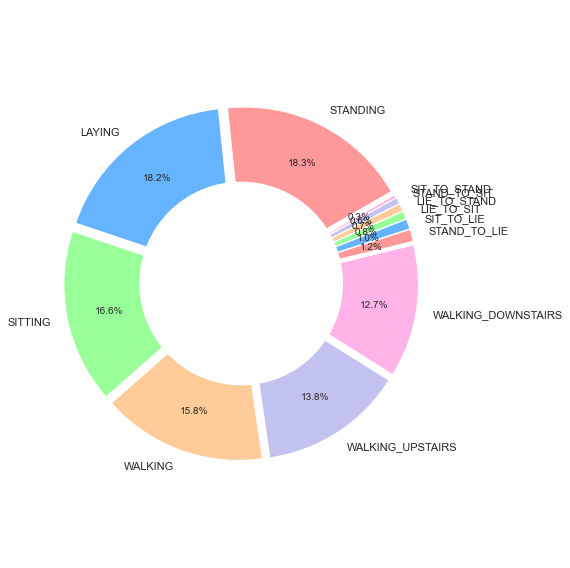

In [15]:
pie_chart(target_count)

In [16]:
target_train.drop('Activity', axis=1, inplace=True)

#### Features

In [17]:
features_train.head(2)

,tBodyAcc-Mean-1,tBodyAcc-Mean-2,tBodyAcc-Mean-3,tBodyAcc-STD-1,tBodyAcc-STD-2,tBodyAcc-STD-3,tBodyAcc-Mad-1,tBodyAcc-Mad-2,tBodyAcc-Mad-3,tBodyAcc-Max-1,...,fBodyGyroJerkMag-MeanFreq-1,fBodyGyroJerkMag-Skewness-1,fBodyGyroJerkMag-Kurtosis-1,tBodyAcc-AngleWRTGravity-1,tBodyAccJerk-AngleWRTGravity-1,tBodyGyro-AngleWRTGravity-1,tBodyGyroJerk-AngleWRTGravity-1,tXAxisAcc-AngleWRTGravity-1,tYAxisAcc-AngleWRTGravity-1,tZAxisAcc-AngleWRTGravity-1
0,0.04358,-0.005970,-0.035054,-0.995381,-0.988366,-0.937382,-0.995007,-0.988816,-0.953325,-0.794796,...,-0.012236,-0.314848,-0.713308,-0.112754,0.030400,-0.464761,-0.018446,-0.841559,0.179913,-0.051718
1,0.03948,-0.002131,-0.029067,-0.998348,-0.982945,-0.971273,-0.998702,-0.983315,-0.974000,-0.802537,...,0.202804,-0.603199,-0.860677,0.053477,-0.007435,-0.732626,0.703511,-0.845092,0.180261,-0.047436


In [18]:
features_train.shape

(7767, 561)

In [19]:
features_train.describe().T

,count,mean,std,min,25%,50%,75%,max
tBodyAcc-Mean-1,7767.0,0.038759,0.101996,-1.000000,0.032037,0.038975,0.044000,1.000000
tBodyAcc-Mean-2,7767.0,-0.000647,0.099974,-1.000000,-0.011209,-0.002921,0.004303,1.000000
tBodyAcc-Mean-3,7767.0,-0.018155,0.089927,-1.000000,-0.028448,-0.019602,-0.011676,1.000000
tBodyAcc-STD-1,7767.0,-0.599017,0.441481,-1.000000,-0.992140,-0.914202,-0.246026,1.000000
tBodyAcc-STD-2,7767.0,-0.634424,0.367558,-1.000000,-0.983570,-0.827970,-0.313069,0.945956
...,...,...,...,...,...,...,...,...
tBodyGyro-AngleWRTGravity-1,7767.0,0.009239,0.601208,-1.000000,-0.470267,0.001515,0.496871,0.998702
tBodyGyroJerk-AngleWRTGravity-1,7767.0,-0.005184,0.477218,-1.000000,-0.373565,-0.005503,0.352690,0.991288
tXAxisAcc-AngleWRTGravity-1,7767.0,-0.485936,0.509278,-1.000000,-0.810953,-0.706619,-0.488765,1.000000
tYAxisAcc-AngleWRTGravity-1,7767.0,0.050310,0.300866,-1.000000,-0.047752,0.176777,0.246834,0.482229


In [20]:
features_train.isnull().any().sum()

0

In [21]:
features_train.select_dtypes(exclude=[np.number]).columns

Index([], dtype='object')

In [22]:
acc    = []
gyro   = []
others = []

for col in features_train.columns:
    
    if 'Acc' in col:
        acc.append(col)
    elif 'Gyro' in col:
        gyro.append(col)
    else:
        others.append(col)
        
print('Accelerometer metrics: {}'.format(len(acc)))
print('Gyroscope metrics: {}'.format(len(gyro)))
print('Others: {}'.format(len(others)))

Accelerometer metrics: 348
Gyroscope metrics: 213
Others: 0


* ### Test

In [23]:
features_test = pd.read_csv('X_test.txt', sep=' ', header=None)
features_test.columns = features_names

target_test = pd.read_csv('y_test.txt', header=None, names=['Target'])

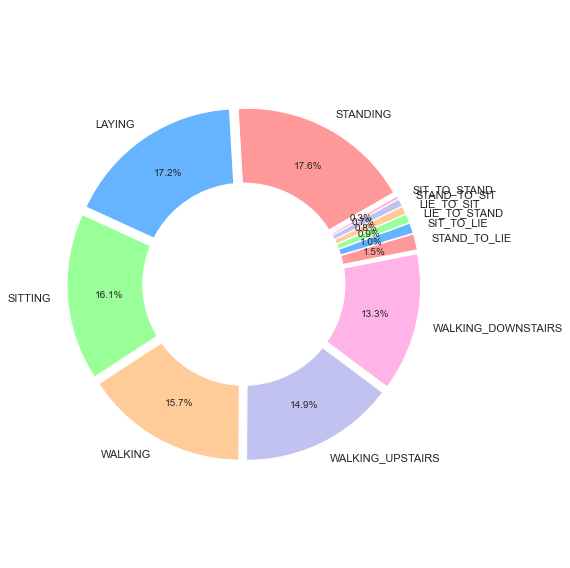

In [24]:
target_test = target_test.merge(label_names, on = 'Target', how = 'left')

target_count_test = target_test['Activity'].value_counts().to_frame().reset_index()
target_count_test.columns = ['Activity', 'Count']

pie_chart(target_count_test)

In [25]:
target_test.drop('Activity', axis=1, inplace=True)

We can see that the proportion of labels in both train and test datasets is balanced, however in terms of the activity itself we can clearly observe a noticeable unbalance on half of the activities, with much less participation.

Before applying any processing step to balance it, we will test a classifier and look at the confusion matrix to see how well it did with these imbalanced cases.

In [26]:
features_test.isnull().any().sum()

0

In [27]:
features_test.select_dtypes(exclude=[np.number]).columns

Index([], dtype='object')

### Process Data - Scaler

The data should be already scaled, as indicated within the instructions, on a range of [-1,1]. However, we will apply another scaler that sets the mean as 0 and variance as 1. 

In [28]:
scaler = StandardScaler()

In [29]:
X_train_scaled = pd.DataFrame(scaler.fit_transform(features_train), columns = features_train.columns)

In [30]:
X_test_scaled = pd.DataFrame(scaler.transform(features_test), columns = features_test.columns)

### Dimensionality Reduction - PCA

Since we have over 500 features in our dataset, it is likely that our model will produce overfitting due to high dimensionality. Thus, we applied PCA as technique to recude the dimensionality on the data.

In [31]:
pca = PCA()

In [32]:
pca_fit = pca.fit(X_train_scaled)

In [33]:
# Investigate the variance accounted for by each principal component.

def scree_plot(pca): # Function from PCA lesson
    '''
    Creates a scree plot associated with the principal components 
    
    INPUT: pca - the result of instantian of PCA in scikit learn
            
    RETURN: None
    '''
    
    num_components= len(pca.explained_variance_ratio_)
    idx = np.arange(num_components)
    vals = pca.explained_variance_ratio_
 
    plt.figure(figsize=(15, 10))
    ax = plt.subplot(111)
    cum_vals = np.cumsum(vals)
    ax.bar(idx, vals)
    ax.plot(idx, cum_vals)
    
    for i in range(num_components):
        if(i % 20 == 0 or i < 6):
            ax.annotate(r'%s%%' % ((str(vals[i]*100)[:4])), (idx[i]+0.2, vals[i]), va='bottom', ha='center', fontsize=8)
 
    ax.xaxis.set_tick_params(width = 0, gridOn = True)
    ax.yaxis.set_tick_params(width = 2, length = 12, gridOn = True)
 
    ax.set_xlabel('Principal Component')
    ax.set_ylabel('Variance Explained (%)')
    plt.title('Explained Variance Per Principal Component')

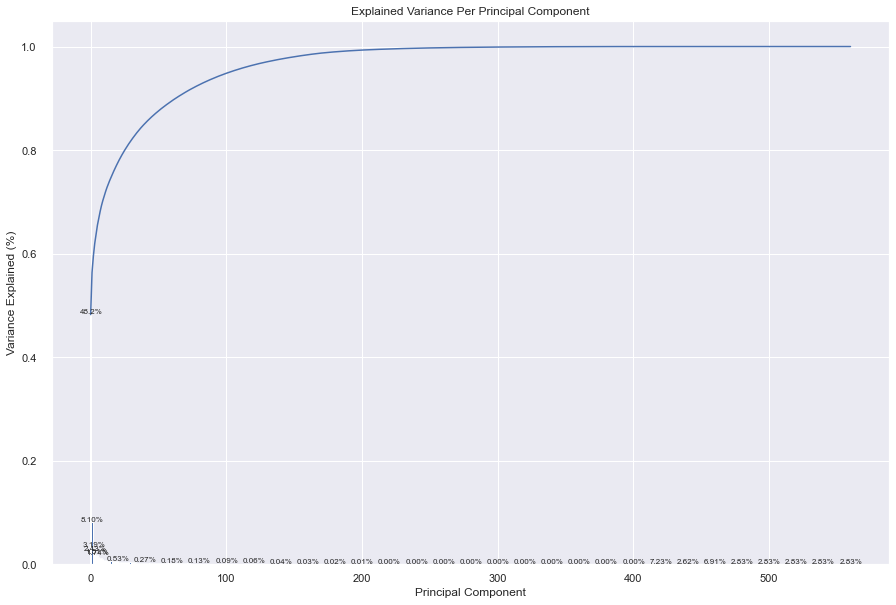

In [34]:
scree_plot(pca_fit)

As an initial step we tested 170 components, which kept almost 100% of the significance of the data and, although the results were good, we wanted to tighten this number a bit, so we finally chose 100 components, which kept aroung 95% of significance, quite a good level as well.

In [35]:
# Re-apply PCA to the data while selecting for number of components to retain
pca = PCA(n_components = 100)

train_pca = pca.fit_transform(X_train_scaled)

In [36]:
test_pca = pca.transform(X_test_scaled)

In [37]:
# Map weights for the first principal component to corresponding feature names
# and then print the linked values, sorted by weight

def principal_components(features, pca, component_idx, num_features):
    
    if component_idx <= len(pca.components_):
    
        weight_features_dict = {'Weight' : pca.components_[component_idx], 
                                'Feature': features}
        
        weight_features_df = pd.DataFrame(weight_features_dict)
        weight_features_df.sort_values('Weight', ascending=False, inplace=True)
    
        print('The {} most significant variables for the component {} and their respective weights are:'.format(num_features, component_idx + 1))
        print(weight_features_df.iloc[:num_features, :])
        print('\n')
        print('The {} least significant variables for the component {} and their respective weights are:'.format(num_features, component_idx + 1))
        print(weight_features_df.iloc[-num_features:, :])

In [38]:
principal_components(X_train_scaled.columns, pca, 0, 3)

The 3 most significant variables for the component 1 and their respective weights are:
       Weight             Feature
280  0.060024      fBodyAcc-SMA-1
438  0.059989     fBodyGyro-SMA-1
359  0.059555  fBodyAccJerk-SMA-1


The 3 least significant variables for the component 1 and their respective weights are:
      Weight             Feature
13 -0.055938      tBodyAcc-Min-2
92 -0.056191  tBodyAccJerk-Min-1
12 -0.056359      tBodyAcc-Min-1


### Model Implementation

In [39]:
def multiclass_roc_auc_score(y_true, y_pred, average = 'macro', multi_class = 'ovr'):
    
    # Binarize labels in a one-vs-all fashion
    # Extend algorithms to multi-class classification case
    lb = LabelBinarizer()
    
    y_true = lb.fit_transform(y_true)
    y_pred = lb.transform(y_pred)
    
    return roc_auc_score(y_true, y_pred, average = average, multi_class = multi_class)

In [40]:
def train_predict(model, X_train, y_train, X_test, y_test):
    
    '''
    inputs:
       - model: the learning algorithm to be trained and predicted on
       - X_train: features training set
       - y_train: target training set
       - X_valid: features testing set
       - y_valid: target testing set
    '''
    
    # Fit the model within the training data, slicing it by 'sample_size'. Obtain training time
    start = time()
    model = model.fit(X_train, y_train)
    end = time()
    
    train_time = end - start
    
    # Predict target on the train and test sets and obtain total prediction time
    start = time()
    predictions_train = model.predict(X_train) # For training, we just predict the first 300 samples
    predictions_test  = model.predict(X_test)
    end = time()
    
    pred_time = end - start
    
    # We will base our results on three different metrics, accuracy, F-Beta score and ROC-AUC
    # This way, we will not just consider the overall results of the model (accuracy), but
    # also false positives and negatives (F-beta and ROC-AUC scores)
    
    # Calculate accuracy
    acc_train = accuracy_score(y_train, predictions_train)
    acc_test  = accuracy_score(y_test, predictions_test)
    
    # Calculate F-beta score
    f_train = fbeta_score(y_train, predictions_train, beta=0.5, average='micro')
    f_test  = fbeta_score(y_test,  predictions_test,  beta=0.5, average='micro')
    
    # Obtain ROC-AUC score
    roc_train = multiclass_roc_auc_score(y_train, predictions_train)
    roc_test  = multiclass_roc_auc_score(y_test, predictions_test)

    print('{}:'.format(model.__class__.__name__))
    print('Accuracy       - Train: {:.2f}, Test: {:.2f}'.format(acc_train, acc_test))
    print('F-score        - Train: {:.2f}, Test: {:.2f}'.format(f_train, f_test))
    print('ROC AUC-score  - Train: {:.2f}, Test: {:.2f}'.format(roc_train, roc_test))
    print('Training time: {:.2f}, Prediction time {:.2f}.\n'.format(train_time, pred_time))

In [41]:
# Initialize models whose performance we are going to test
clf_A = LogisticRegression(random_state = 42)
clf_B = RandomForestClassifier(random_state = 42)
clf_C = AdaBoostClassifier(random_state = 42)
clf_D = XGBClassifier(random_state = 42)

models = [clf_A, clf_B, clf_C, clf_D]

In [42]:
for clf in models:
    train_predict(clf, train_pca, target_train, test_pca, target_test)

/Users/jessicagarre/opt/anaconda3/lib/python3.8/site-packages/sklearn/utils/validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
/Users/jessicagarre/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
<ipython-input-40-ed22f0cf7a60>:14: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  mod

LogisticRegression:
Accuracy       - Train: 0.98, Test: 0.92
F-score        - Train: 0.98, Test: 0.92
ROC AUC-score  - Train: 0.99, Test: 0.91
Training time: 0.68, Prediction time 0.00.

RandomForestClassifier:
Accuracy       - Train: 1.00, Test: 0.87
F-score        - Train: 1.00, Test: 0.87
ROC AUC-score  - Train: 1.00, Test: 0.85
Training time: 6.65, Prediction time 0.23.



/Users/jessicagarre/opt/anaconda3/lib/python3.8/site-packages/sklearn/utils/validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)


AdaBoostClassifier:
Accuracy       - Train: 0.34, Test: 0.33
F-score        - Train: 0.34, Test: 0.33
ROC AUC-score  - Train: 0.55, Test: 0.55
Training time: 5.44, Prediction time 0.27.



/Users/jessicagarre/opt/anaconda3/lib/python3.8/site-packages/sklearn/utils/validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)


XGBClassifier:
Accuracy       - Train: 1.00, Test: 0.89
F-score        - Train: 1.00, Test: 0.89
ROC AUC-score  - Train: 1.00, Test: 0.87
Training time: 33.31, Prediction time 0.85.



We can see that Logistic Regression is the model with best performance, both in training and testing (Random Forest and XGBoost completely overfit, and AdaBoost gives poor results). 

Thus, we chose it as the classifier for our dataset. Now we will optimize its parameters with Grid Search. 

In [43]:
pipe = Pipeline([('classifier' , LogisticRegression(random_state=42))])

# Create param grid.
param_grid = {'classifier__penalty': ['l1', 'l2'],
              'classifier__C'      : np.logspace(-4, 4, 20),
              'classifier__solver' : ['liblinear']}

# Create grid search object

clf = GridSearchCV(pipe, param_grid = param_grid, cv = 5, verbose=True, n_jobs=-1)

In [44]:
grid_fit = clf.fit(train_pca, target_train)

Fitting 5 folds for each of 40 candidates, totalling 200 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:   21.1s
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed: 58.9min
[Parallel(n_jobs=-1)]: Done 200 out of 200 | elapsed: 59.8min finished
/Users/jessicagarre/opt/anaconda3/lib/python3.8/site-packages/sklearn/utils/validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
/Users/jessicagarre/opt/anaconda3/lib/python3.8/site-packages/sklearn/svm/_base.py:976: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "


In [45]:
# Obtain best estimator
best_clf = grid_fit.best_estimator_
best_clf

Pipeline(steps=[('classifier',
                 LogisticRegression(C=0.615848211066026, penalty='l1',
                                    random_state=42, solver='liblinear'))])

In [46]:
best_pred  = best_clf.predict(test_pca)
best_pred_train  = best_clf.predict(train_pca)

In [47]:
print('Final accuracy - Train: {:.3f}, Test: {:.3f}'.format(accuracy_score(target_train, best_pred_train), accuracy_score(target_test, best_pred)))
print('Final F-score  - Train: {:.3f}, Test: {:.3f}\n'.format(fbeta_score(target_train, best_pred_train, beta = 0.5, average='micro'), fbeta_score(target_test, best_pred, beta = 0.5, average='micro')))
print('Final ROC-AUC  - Train: {:.3f}, Test: {:.3f}'.format(multiclass_roc_auc_score(target_train, best_pred_train), multiclass_roc_auc_score(target_test, best_pred)))

Final accuracy - Train: 0.972, Test: 0.914
Final F-score  - Train: 0.972, Test: 0.914

Final ROC-AUC  - Train: 0.979, Test: 0.906


Our metrics indicate that, even though there is a slight overfitting, the results are overall quite good.

However, as mentioned earlier in the project, the target labels were imbalanced, thus we want to check if our model performs well and classifies correctly the least present labels as well. For that, we will obtain the confusion matrix for all the classes and the ROC curve for each label.

In [48]:
confusion_matrix(target_test, best_pred)

array([[491,   1,   4,   0,   0,   0,   0,   0,   0,   0,   0,   0],
       [ 43, 411,  16,   0,   0,   0,   0,   0,   0,   0,   1,   0],
       [  9,  24, 387,   0,   0,   0,   0,   0,   0,   0,   0,   0],
       [  0,   2,   0, 432,  73,   0,   1,   0,   0,   0,   0,   0],
       [  1,   0,   0,  42, 513,   0,   0,   0,   0,   0,   0,   0],
       [  1,   0,   0,   0,   0, 544,   0,   0,   0,   0,   0,   0],
       [  0,   1,   0,   2,   2,   0,  17,   0,   0,   0,   1,   0],
       [  0,   0,   0,   0,   0,   0,   0,  10,   0,   0,   0,   0],
       [  0,   1,   0,   0,   0,   0,   0,   0,  17,   0,  13,   1],
       [  0,   0,   0,   0,   0,   0,   0,   0,   0,  18,   0,   7],
       [  3,   2,   0,   0,   1,   1,   0,   0,  11,   0,  31,   0],
       [  0,   0,   0,   0,   0,   0,   0,   0,   0,   7,   2,  18]])

Class WALKING (1):


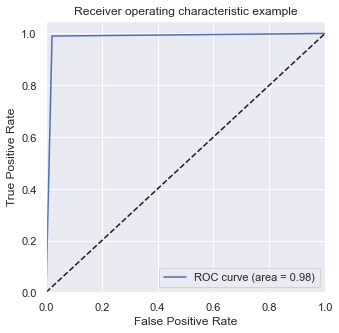

Class WALKING_UPSTAIRS (2):


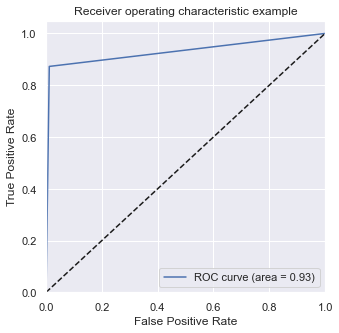

Class WALKING_DOWNSTAIRS (3):


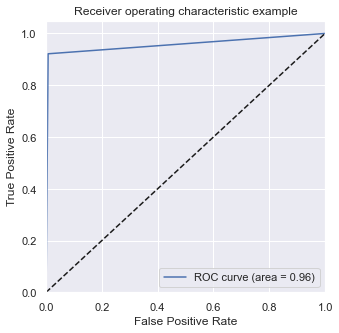

Class SITTING (4):


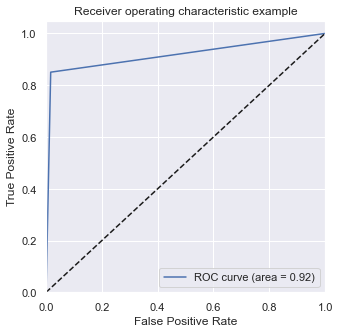

Class STANDING (5):


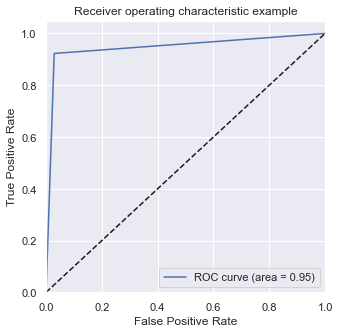

Class LAYING (6):


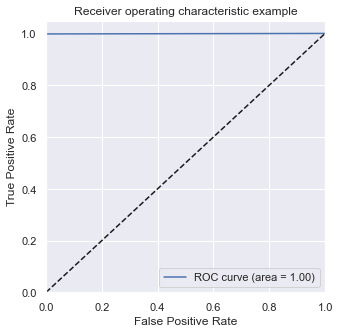

Class STAND_TO_SIT (7):


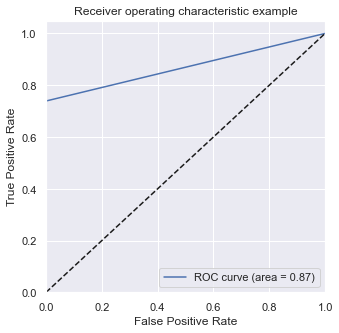

Class SIT_TO_STAND (8):


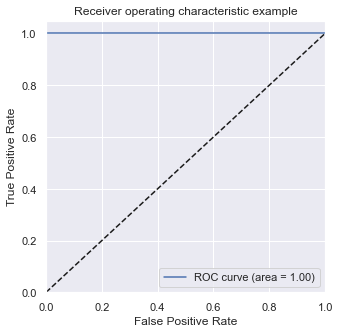

Class SIT_TO_LIE (9):


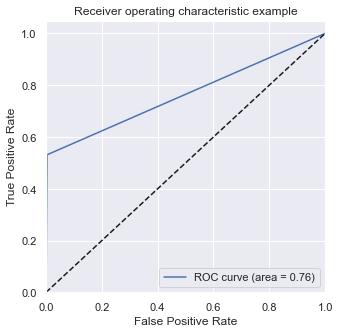

Class LIE_TO_SIT (10):


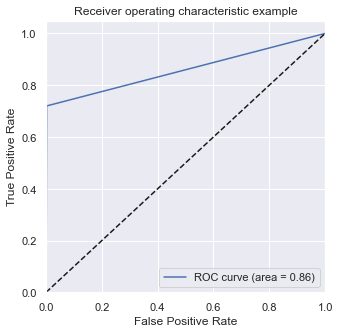

Class STAND_TO_LIE (11):


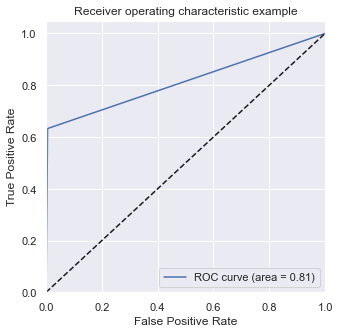

Class LIE_TO_STAND (12):


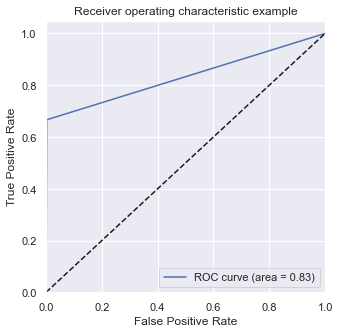

In [49]:
lb = LabelBinarizer()
    
y_test = lb.fit_transform(target_test)
y_score = lb.transform(best_pred)

n_classes = len(label_names)

# Compute ROC curve and ROC area for each class
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test[:, i], y_score[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Plot of a ROC curve for a specific class
for i in range(n_classes):
    
    print('Class {} ({}):'.format(label_names.Activity.iloc[i], i+1))
    
    plt.figure(figsize = [5, 5])
    
    plt.plot(fpr[i], tpr[i], label='ROC curve (area = %0.2f)' % roc_auc[i])
    plt.plot([0, 1], [0, 1], 'k--')
    
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver operating characteristic example')
    plt.legend(loc = 'lower right')
    plt.show()

From the results we can see that the model is able to capture quite well most classes. 

It is true that for the classes with less participation (the last 6) the results are a bit worst - specially the last 3 - but, overall, we can affirm that there is a good performance, so we accept this classifier. 